In [1]:
import sys
sys.path.insert(1, './src/')
sys.path.insert(2, './scripts/')

In [18]:
import numpy as np
import pandas as pd
from rouge import Rouge
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

## Step 1. Load datasets

In [5]:
# Read dataset.
def load_dataset(dataset_path: str) -> pd.DataFrame:
    df = pd.read_csv(dataset_path)
    df.dropna(inplace=True) # Drop null values (if any)
    return df

In [28]:
df_train = load_dataset(r'../data/cnn_dailymail/train.csv')
df_train['highlights'] = df_train['highlights'].str.replace('\n', ' ', regex=True)
df_train['highlights'] = df_train['highlights'].str.replace(' \.', '.', regex=True)

df_val = load_dataset(r'../data/cnn_dailymail/validation.csv')
df_val['highlights'] = df_val['highlights'].str.replace('\n', ' ', regex=True)
df_val['highlights'] = df_val['highlights'].str.replace(' \.', '.', regex=True)

df_test = load_dataset(r'../data/cnn_dailymail/test.csv')
df_test['highlights'] = df_test['highlights'].str.replace('\n', ' ', regex=True)
df_test['highlights'] = df_test['highlights'].str.replace(' \.', '.', regex=True)

In [7]:
df_test[['id', 'highlights']]

,id,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,"Tell-all interview with the reality TV star, 6..."
...,...,...
11485,ed8674cc15b29a87d8df8de1efee353d71122272,Oxford scientists say a Mercury-like body stru...
11486,2f58d1a99e9c47914e4b1c31613e3a041cd9011e,Man accused of helping former lover kill woman...
11487,411f6d57825161c3a037b4742baccd6cd227c0c3,Marianne Power tried the tuning fork facial at...
11488,b5683ef8342056b17b068e0d59bdbe87e3fe44ea,Brooklyn Nets beat the Portland Trail Blazers ...


## Step 2. Load model

In [ ]:
from src.extractive import ExtractiveSummarizer
model = ExtractiveSummarizer.load_from_checkpoint("./models/distilbert.ckpt")

## Step 3. Qualitative Investigation

In [32]:
article = df_train['article'][0]
summary = model.predict(article)
print(summary)
summary.split('.')

The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo , Grand Forks and Jamestown to the hepatitis A virus in late September and early October. Bishop John Folda ( pictured ) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo , Grand Forks and Jamestown to the hepatitis A. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month.


['The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo , Grand Forks and Jamestown to the hepatitis A virus in late September and early October',
 ' Bishop John Folda ( pictured ) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo , Grand Forks and Jamestown to the hepatitis A',
 ' The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A',
 ' The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month',
 '']

## Step 4. Infer on Testset

The code cell below is sufficient for step 4 as it encapusulates every step we need to generate the results.

In [ ]:
try:
    results = pd.read_csv('./pred/distilbert.csv')
except:
    results = pd.DataFrame(data=df_test[['id', 'highlights']])
    results.rename(columns={'highlights':'actual_summary'}, inplace=True)
    results['pred_summary'] = df_test.apply(lambda row:
                                            model.predict(row.article),
                                            axis=1)
    rouge = Rouge()
    rouge_scores = rouge.get_scores(hyps=results['pred_summary'],
                                    refs=results['actual_summary'])
    results['rogue1_f1'] = [record['rouge-1']['f']for record in rouge_scores]
    results['rogue2_f1'] = [record['rouge-2']['f']for record in rouge_scores]
    results['rogueL_f1'] = [record['rouge-l']['f']for record in rouge_scores]
    results.to_csv('./pred/distilbert.csv', index=False)

Alternatively, we can run the following code cells to check the `results` step by step. The outcome are the same.

In [9]:
results = pd.DataFrame(data=df_test[['id', 'highlights']])
results.rename(columns={'highlights':'actual_summary'}, inplace=True)

In [10]:
results['pred_summary'] = df_test.apply(lambda row: model.predict(row.article), axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (1041 > 512). Running this sequence through the model will result in indexing errors


In [11]:
rouge = Rouge()
rouge_scores = rouge.get_scores(hyps=results['pred_summary'],
                                refs=results['actual_summary'])
results['rogue1_f1'] = [record['rouge-1']['f']for record in rouge_scores]
results['rogue2_f1'] = [record['rouge-2']['f']for record in rouge_scores]
results['rogueL_f1'] = [record['rouge-l']['f']for record in rouge_scores]

In [12]:
results

,id,actual_summary,pred_summary,rogue1_f1,rogue2_f1,rogueL_f1
0,92c514c913c0bdfe25341af9fd72b29db544099b,Experts question if packed out planes are put...,"This week , a U.S consumer advisory group set ...",0.297030,0.117647,0.297030
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,Drunk teenage boy climbed into lion enclosure ...,"Rahul Kumar , 17 , clambered over the enclosur...",0.413793,0.105263,0.344828
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Nottingham Forest are close to extending Dougi...,Dougie Freedman is on the verge of agreeing a ...,0.406780,0.144928,0.338983
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Fiorentina goalkeeper Neto has been linked wit...,Liverpool target Neto is also wanted by PSG an...,0.428571,0.203390,0.346939
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,"Tell-all interview with the reality TV star, 6...",Bruce Jenner will break his silence in a two -...,0.508772,0.262069,0.508772
...,...,...,...,...,...,...
11485,ed8674cc15b29a87d8df8de1efee353d71122272,Oxford scientists say a Mercury-like body stru...,Oxford scientists say a Mercury - like body st...,0.695652,0.625000,0.695652
11486,2f58d1a99e9c47914e4b1c31613e3a041cd9011e,Man accused of helping former lover kill woman...,"Micheal John Duffy , 34 , pleaded not guilty t...",0.462585,0.211055,0.448980
11487,411f6d57825161c3a037b4742baccd6cd227c0c3,Marianne Power tried the tuning fork facial at...,I 'm here to try the wackiest face treatment t...,0.423529,0.276596,0.423529
11488,b5683ef8342056b17b068e0d59bdbe87e3fe44ea,Brooklyn Nets beat the Portland Trail Blazers ...,Brook Lopez dominated twin brother Robin with ...,0.359551,0.148148,0.359551


In [13]:
results.to_csv('./pred/distilbert.csv', index=False)

## Step 5. Quantitative Investigation

In [19]:
rouge1_f1 = results['rogue1_f1']
rouge2_f1 = results['rogue2_f1']
rougeL_f1 = results['rogueL_f1']
avg_rouge1_f1 = rouge1_f1.mean()
avg_rouge2_f1 = rouge2_f1.mean()
avg_rougeL_f1 = rougeL_f1.mean()

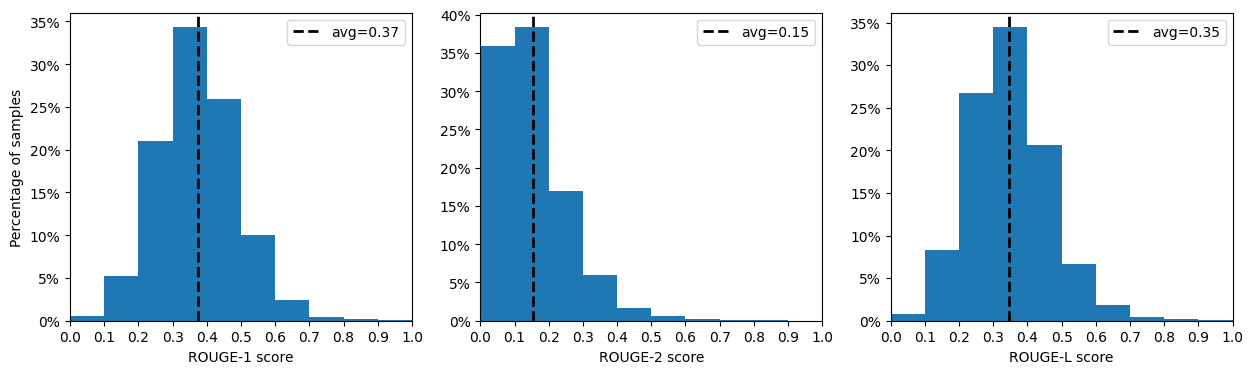

In [25]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(rouge1_f1, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(rouge1_f1))/len(rouge1_f1))
plt.axvline(x=avg_rouge1_f1, ls='--', lw=2, c='black', label=f'avg={avg_rouge1_f1:.2f}')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('ROUGE-1 score')
plt.ylabel('Percentage of samples')

plt.subplot(1, 3, 2)
plt.hist(rouge2_f1, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(rouge2_f1))/len(rouge2_f1))
plt.axvline(x=avg_rouge2_f1, ls='--', lw=2, c='black', label=f'avg={avg_rouge2_f1:.2f}')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('ROUGE-2 score')

plt.subplot(1, 3, 3)
plt.hist(rougeL_f1, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(rougeL_f1))/len(rougeL_f1))
plt.axvline(x=avg_rougeL_f1, ls='--', lw=2, c='black', label=f'avg={avg_rougeL_f1:.2f}')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('ROUGE-L score')

plt.show()